Our Revised Strategy :

1. The galaxy zoo challenge wanted us to predict the distribution out of 37 classes for each of the images in test using training_solutions_rev1.csv.. meaning it's a regression problem.

## our innovation : in line with https://cs229.stanford.edu/proj2016/report/GauthierJainNoordeh-GalaxyMorphology-report.pdf we converted galaxy zoo to a classification problem where the training galaxies are one of disc, spiral,	elliptical,	round,	other. We took a qualitative classification using the decision tree given Table 2 of https://arxiv.org/pdf/1308.3496.pdf - it's a little different from Hubble classification but should demonstrate feasibility of our automation techniques in galaxy classification.

Disc (disc):

Identified by responses indicating the galaxy is viewed edge-on (Question 2) and has a disk structure (Question 7).
Probability values in Class1.2 are considered for this category.

Spiral (spiral):

Identified by responses indicating the presence of spiral arms (Question 4 and Question 11).
Probability values in Class1.3 and Class11.1 are considered for this category.

Elliptical (elliptical):

Identified by responses indicating the galaxy is smooth and rounded with no signs of features or disk (Question 1).
Probability values in Class1.1 are considered for this category.

Round (round):

Identified by responses indicating the galaxy is simply smooth and rounded (Question 1) or has an odd feature such as a ring or lens (Question 8).
Probability values in Class1.1 and Class7.1 are considered for this category.

Other (other):

Assigned to galaxies that don't fit into the above categories, including those with irregularities, disturbances, or features not captured in the primary categories.
Assigned if none of the above conditions are met in the decision tree.

## Steps for our semi supervised learning:
## Initial Training:

Use your labeled dataset (61578 labeled galaxy images) to train your SVM and KNN models. Divide the labeled data into training and validation sets for model evaluation.

## SVM and KNN Prediction:

Use the trained SVM and KNN models to predict labels for the unlabeled dataset (79975 images). These predictions become pseudo-labels.
## Pseudo-labeling:

Combine the pseudo-labels with the labeled dataset, creating a larger dataset for further training.

## Semi-supervised Learning:

Retrain your SVM and KNN models using the combined dataset.

## K-Means Clustering:

Use K-Means clustering on the unlabeled dataset, treating each cluster as a separate class. Assign the cluster labels to the images in each cluster.
Combining Predictions:

Combine the predictions from SVM, KNN, and K-Means for each image. For example, you could use a majority voting scheme.
Model Evaluation:

Use your validation set to evaluate the performance of your models, and possibly tune hyperparameters.

## Confusion Matrix:

Generate a confusion matrix using the true labels and the combined predictions. Calculate metrics such as accuracy, precision, recall, and F1-score for each class.

Data Split:

You might consider an initial split of the labeled dataset, e.g., 80% for training and 20% for validation.
For the unlabeled dataset, you can use a portion for initial clustering and the rest for semi-supervised learning.
Adjust the ratios based on the size of your datasets and computational resources.

Confusion Matrix:

Create a confusion matrix using the true labels and the final predictions (combined predictions from SVM, KNN, and K-Means).
For a 5-class problem, the confusion matrix would be a 5x5 matrix where each row represents the true class, and each column represents the predicted class.

In [1]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os
from PIL import Image
import re

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Setting your directories
DATA_DIR = '/content/drive/MyDrive/Galaxy_Morphology/'
LABELED_OUTPUT_DIR = DATA_DIR + 'label_preprocess/final/'
UNLABELED_OUTPUT_DIR = DATA_DIR + 'unlabel_preprocess/final/'

In [8]:

labeled_data = pd.read_csv(DATA_DIR+'galaxy_5classes.csv')

# Split labeled data into training and validation sets 80p train 20p validation
#train_data, valid_data = train_test_split(labeled_data, test_size=0.2, random_state=42)

In [9]:
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61578 entries, 0 to 61577
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GalaxyID    61578 non-null  float64
 1   disc        61578 non-null  float64
 2   spiral      61578 non-null  float64
 3   elliptical  61578 non-null  float64
 4   round       61578 non-null  float64
 5   other       61578 non-null  float64
dtypes: float64(6)
memory usage: 2.8 MB


In [10]:
# Function to extract numeric ID from image filename
def extract_numeric_id(filename):
    match = re.search(r'\d+', filename)
    return float(match.group()) if match else None

# Get the list of files in the labeled output directory
labeled_files = os.listdir(LABELED_OUTPUT_DIR)

# Extract numeric IDs from image filenames and convert to float64
numeric_ids = [float(extract_numeric_id(filename)) for filename in labeled_files]

# Read the labeled data CSV file
labeled_data = pd.read_csv(DATA_DIR + 'galaxy_5classes.csv')

# Convert 'GalaxyID' column to float64 for comparison
labeled_data['GalaxyID'] = labeled_data['GalaxyID'].astype(float)

# Filter the labeled data based on the numeric IDs
filtered_labeled_data = labeled_data[labeled_data['GalaxyID'].isin(numeric_ids)]

# Create a new DataFrame with the filtered data
filtered_labeled_dataframe = pd.DataFrame(filtered_labeled_data)

# Display the new DataFrame
print(filtered_labeled_dataframe)


       GalaxyID  disc  spiral  elliptical  round  other
60     100894.0   1.0     0.0         0.0    0.0    0.0
62     100951.0   0.0     0.0         0.0    0.0    1.0
79     101246.0   0.0     0.0         0.0    1.0    0.0
91     101315.0   0.0     0.0         0.0    0.0    1.0
93     101325.0   0.0     0.0         0.0    1.0    0.0
...         ...   ...     ...         ...    ...    ...
50187  830465.0   1.0     0.0         0.0    0.0    0.0
50194  830609.0   0.0     0.0         0.0    0.0    1.0
50220  830956.0   0.0     0.0         0.0    1.0    0.0
50489  835216.0   0.0     0.0         0.0    0.0    1.0
50877  841118.0   0.0     0.0         0.0    0.0    1.0

[2407 rows x 6 columns]


In [ ]:
# Exclude 'GalaxyID' column from calculation
class_counts = filtered_labeled_dataframe.drop('GalaxyID', axis=1).sum()
total_samples = len(filtered_labeled_dataframe)

# Calculate percentages and include the count of 1s
percentage_df = (class_counts / total_samples * 100).to_frame(name='Percentage')
percentage_df['Count'] = class_counts

# Display the result
print(percentage_df)


            Percentage  Count
disc         33.610303  809.0
spiral        0.000000    0.0
elliptical    0.000000    0.0
round        33.236394  800.0
other        33.153303  798.0


In [ ]:
percentage_df


,Percentage,Count
disc,33.610303,809.0
spiral,0.000000,0.0
elliptical,0.000000,0.0
round,33.236394,800.0
other,33.153303,798.0


In [ ]:
# Assuming 'percentage_df' is your DataFrame
filtered_labeled_dataframe.drop(['spiral', 'elliptical'], axis=1, inplace=True)

# Display the modified DataFrame
print(filtered_labeled_dataframe)


       GalaxyID  disc  round  other
60     100894.0   1.0    0.0    0.0
62     100951.0   0.0    0.0    1.0
79     101246.0   0.0    1.0    0.0
91     101315.0   0.0    0.0    1.0
93     101325.0   0.0    1.0    0.0
...         ...   ...    ...    ...
50187  830465.0   1.0    0.0    0.0
50194  830609.0   0.0    0.0    1.0
50220  830956.0   0.0    1.0    0.0
50489  835216.0   0.0    0.0    1.0
50877  841118.0   0.0    0.0    1.0

[2407 rows x 4 columns]


In [11]:
# Split filtered labeled data into training and validation sets 80p train, 20p validation
train_data, valid_data = train_test_split(filtered_labeled_dataframe, test_size=0.2, random_state=42)

In [ ]:
train_data

,GalaxyID,disc,round,other
33533,591280.0,0.0,0.0,1.0
734,110844.0,0.0,0.0,1.0
43502,734819.0,1.0,0.0,0.0
46538,778547.0,1.0,0.0,0.0
47050,785768.0,0.0,1.0,0.0
...,...,...,...,...
33423,589674.0,1.0,0.0,0.0
21482,413688.0,0.0,0.0,1.0
22212,424771.0,1.0,0.0,0.0
25744,476421.0,1.0,0.0,0.0


In [ ]:
# Exclude 'GalaxyID' column from calculation
class_counts = train_data.drop('GalaxyID', axis=1).sum()
total_samples = len(train_data)

# Calculate percentages and include the count of 1s
percentage_df_train_data = (class_counts / total_samples * 100).to_frame(name='Percentage')
percentage_df_train_data['Count'] = class_counts

# Display the result
print(percentage_df_train_data)

       Percentage  Count
disc    33.766234  650.0
round   33.142857  638.0
other   33.090909  637.0


In [ ]:
# Exclude 'GalaxyID' column from calculation
class_counts = valid_data.drop('GalaxyID', axis=1).sum()
total_samples = len(valid_data)

# Calculate percentages and include the count of 1s
percentage_df_valid_data = (class_counts / total_samples * 100).to_frame(name='Percentage')
percentage_df_valid_data['Count'] = class_counts

# Display the result
print(percentage_df_valid_data)

       Percentage  Count
disc    32.987552  159.0
round   33.609959  162.0
other   33.402490  161.0


In [ ]:
print(len(train_data),len(valid_data))

1925 482


In [12]:
# Func to Load images for labeled data
def load_images(data, data_dir):
    images = []
    labels = []
    #let's allow missing/corrupt files
    for idx, row in data.iterrows():
      try:
        image_path = os.path.join(data_dir, f"{int(row['GalaxyID'])}.png")
        image = Image.open(image_path)
        images.append(np.array(image))
        labels.append(row[['disc', 'round', 'other']].values)
      except:
        pass

    return np.array(images), np.array(labels)

In [ ]:
train_images, train_labels = load_images(train_data, LABELED_OUTPUT_DIR)

In [13]:
valid_images, valid_labels = load_images(valid_data, LABELED_OUTPUT_DIR)

## Training & saving models

In [ ]:
# SVM Model
svm_model = SVC(probability=True)
svm_model.fit(train_images.reshape(train_images.shape[0], -1), np.argmax(train_labels, axis=1))

# Save SVM model
joblib.dump(svm_model, DATA_DIR +'svm_model.joblib')

['/content/drive/MyDrive/Galaxy_Morphology/svm_model.joblib']

In [ ]:
# KNN Model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(train_images.reshape(train_images.shape[0], -1), np.argmax(train_labels, axis=1))

# Save KNN model
joblib.dump(knn_model,DATA_DIR+'knn_model.joblib')

['/content/drive/MyDrive/Galaxy_Morphology/knn_model.joblib']

In [ ]:
# Load unlabeled images directly from the directory
unlabeled_image_ids = [int(filename.split('.')[0]) for filename in os.listdir(UNLABELED_OUTPUT_DIR)]
unlabeled_images = []

In [ ]:
for image_id in unlabeled_image_ids:
  #let's skip over missing or corrupt file
  try:
    image_path = os.path.join(UNLABELED_OUTPUT_DIR, f"{image_id}.png")
    image = Image.open(image_path)
    unlabeled_images.append(np.array(image))
  except:
    pass
unlabeled_images = np.array(unlabeled_images)

In [ ]:
# KMeans Model
num_clusters = 3  # Assuming 3 classes
kmeans = KMeans(n_clusters=num_clusters, random_state=42,  n_init=5)
kmeans.fit(unlabeled_images.reshape(unlabeled_images.shape[0], -1))

# Save KMeans model
joblib.dump(kmeans,DATA_DIR+'kmeans_model.joblib')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


['/content/drive/MyDrive/Galaxy_Morphology/kmeans_model.joblib']

In [ ]:
kmeans_model = joblib.load(DATA_DIR+'kmeans_model.joblib')

In [6]:
svm_model=joblib.load(DATA_DIR +'svm_model.joblib')
knn_model=joblib.load(DATA_DIR+'knn_model.joblib')

## Validation of our models - added code for confusion matrix but please report classification metric as well

In [14]:
svm_valid_predictions = svm_model.predict(valid_images.reshape(valid_images.shape[0], -1))
svm_probabilities = svm_model.predict_proba(valid_images.reshape(valid_images.shape[0], -1))

In [20]:
svm_probabilities

array([[0.26486816, 0.37865804, 0.3564738 ],
       [0.27239706, 0.16099451, 0.56660843],
       [0.20503979, 0.5594967 , 0.23546352],
       ...,
       [0.23790414, 0.5648528 , 0.19724307],
       [0.64723706, 0.08582191, 0.26694102],
       [0.64759341, 0.13152965, 0.22087695]])

In [15]:
knn_valid_predictions = knn_model.predict(valid_images.reshape(valid_images.shape[0], -1))
knn_probabilities = knn_model.predict_proba(valid_images.reshape(valid_images.shape[0], -1))

In [21]:
knn_probabilities

array([[0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.66666667, 0.33333333],
       [0.        , 1.        , 0.        ],
       ...,
       [0.        , 1.        , 0.        ],
       [0.66666667, 0.33333333, 0.        ],
       [0.66666667, 0.33333333, 0.        ]])

In [22]:
# Combine predictions using a voting scheme
#combined_valid_predictions = np.array([np.argmax(np.bincount(votes)) for votes in zip(svm_valid_predictions, knn_valid_predictions)])
combined_valid_predictions = np.array([svm_pred if svm_prob > knn_prob else knn_pred
                                       for svm_pred, knn_pred, svm_prob, knn_prob in zip(svm_valid_predictions, knn_valid_predictions, svm_probabilities.max(axis=1), knn_probabilities.max(axis=1))])

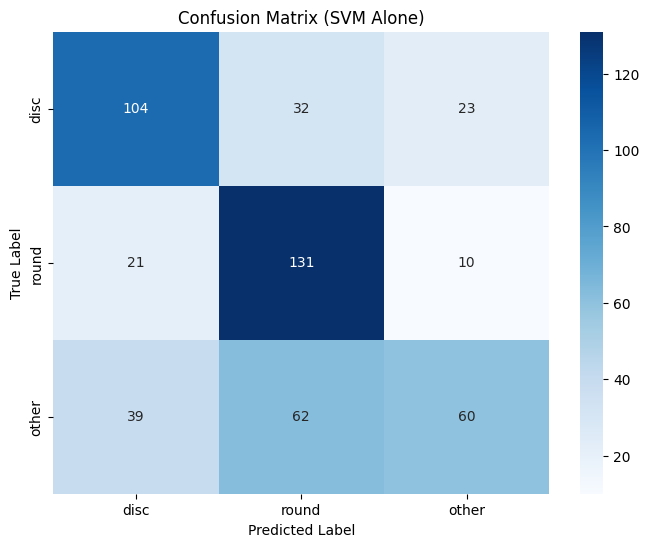

In [ ]:
## Confusion Matrix of SVM ALONE

conf_matrix = confusion_matrix(np.argmax(valid_labels, axis=1), svm_valid_predictions)

# Display seaborn heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['disc', 'round', 'other'], yticklabels=['disc', 'round', 'other'])
plt.title('Confusion Matrix (SVM Alone)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Specify the correct class names present in your dataset
class_names = ['disc', 'round', 'other']

# Calculate and display classification report for SVM model
print("Classification Report for SVM Model:")
print(classification_report(np.argmax(valid_labels, axis=1), svm_valid_predictions, target_names=class_names))

# Calculate and display accuracy for SVM model
accuracy_svm = accuracy_score(np.argmax(valid_labels, axis=1), svm_valid_predictions)
print(f"Accuracy for SVM Model: {accuracy_svm:.4f}")


Classification Report for SVM Model:
              precision    recall  f1-score   support

        disc       0.63      0.65      0.64       159
       round       0.58      0.81      0.68       162
       other       0.65      0.37      0.47       161

    accuracy                           0.61       482
   macro avg       0.62      0.61      0.60       482
weighted avg       0.62      0.61      0.60       482

Accuracy for SVM Model: 0.6120


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate and display accuracy for SVM model
accuracy_svm = accuracy_score(np.argmax(valid_labels, axis=1), svm_valid_predictions)
print(f"Accuracy for SVM Model: {accuracy_svm:.4f}")


Accuracy for SVM Model: 0.6120


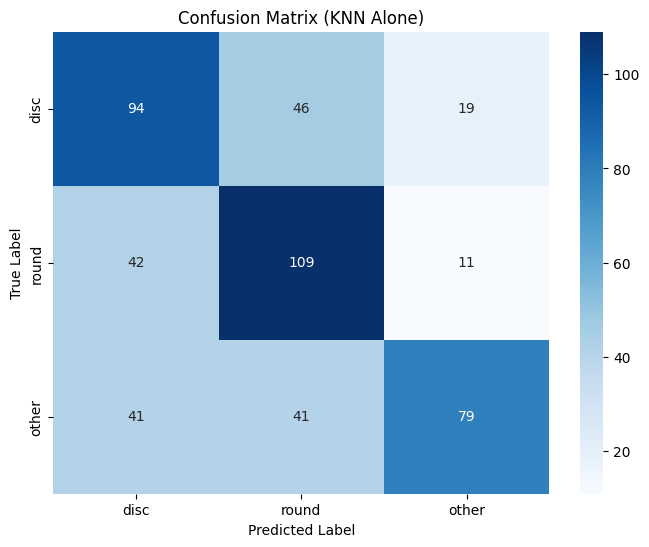

In [ ]:
##Confusion Matrix of KNN ALONE
# Calculate confusion matrix for combined predictions on validation set
conf_matrix = confusion_matrix(np.argmax(valid_labels, axis=1), knn_valid_predictions)

# Display seaborn heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['disc', 'round', 'other'], yticklabels=['disc', 'round', 'other'])
plt.title('Confusion Matrix (KNN Alone)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for KNN model
accuracy_knn = accuracy_score(np.argmax(valid_labels, axis=1), knn_valid_predictions)
print(f"Accuracy for KNN Model: {accuracy_knn:.4f}")


Accuracy for KNN Model: 0.5851


In [ ]:
from sklearn.metrics import classification_report

# Calculate classification report for KNN model
knn_classification_report = classification_report(np.argmax(valid_labels, axis=1), knn_valid_predictions, target_names=['disc','round', 'other'])

# Display the classification report
print("Classification Report for KNN Model:")
print(knn_classification_report)


Classification Report for KNN Model:
              precision    recall  f1-score   support

        disc       0.53      0.59      0.56       159
       round       0.56      0.67      0.61       162
       other       0.72      0.49      0.59       161

    accuracy                           0.59       482
   macro avg       0.60      0.58      0.58       482
weighted avg       0.60      0.59      0.58       482



In [ ]:
#IGNORE THIS PART for KMEANS

"""
# Predictions with KMeans model
kmeans_valid_predictions = kmeans_model.predict(valid_images.reshape(valid_images.shape[0], -1))

# Confusion Matrix of KMeans ALONE
conf_matrix_kmeans = confusion_matrix(np.argmax(valid_labels, axis=1), kmeans_valid_predictions)

# Display seaborn heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_kmeans, annot=True, fmt='d', cmap='Blues', xticklabels=['disc', 'round', 'other'], yticklabels=['disc', 'round', 'other'])
plt.title('Confusion Matrix (KMeans)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

"""

NameError: name 'kmeans_model' is not defined

In [ ]:
"""# Calculate accuracy for KMeans model
accuracy_kmeans = accuracy_score(np.argmax(valid_labels, axis=1), kmeans_valid_predictions)
print(f"Accuracy for KMeans Model: {accuracy_kmeans:.4f}")"""



Accuracy for KMeans Model: 0.3050


In [ ]:
"""# Calculate classification report for KMeans model
kmeans_classification_report = classification_report(np.argmax(valid_labels, axis=1), kmeans_valid_predictions, target_names=['disc', 'round', 'other'])

# Display the classification report for KMeans model
print("Classification Report for KMeans Model:")
print(kmeans_classification_report)"""

Classification Report for KMeans Model:
              precision    recall  f1-score   support

        disc       0.24      0.31      0.27       159
       round       0.46      0.29      0.36       162
       other       0.29      0.31      0.30       161

    accuracy                           0.30       482
   macro avg       0.33      0.31      0.31       482
weighted avg       0.33      0.30      0.31       482



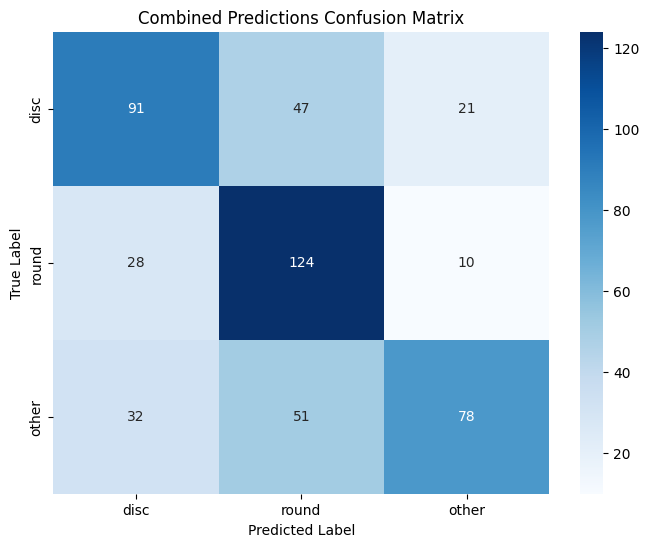

In [25]:
# Confusion Matrix of Combined Predictions
conf_matrix_combined = confusion_matrix(np.argmax(valid_labels, axis=1), combined_valid_predictions)

# Display seaborn heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_combined, annot=True, fmt='d', cmap='Blues', xticklabels=['disc', 'round', 'other'], yticklabels=['disc', 'round', 'other'])
plt.title('Combined Predictions Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [27]:
from sklearn.metrics import classification_report, accuracy_score
# Calculate and display classification report for Combined Predictions
combined_classification_report = classification_report(np.argmax(valid_labels, axis=1), combined_valid_predictions, target_names=['disc', 'round', 'other'])
print("Classification Report for Combined Predictions:")
print(combined_classification_report)

# Calculate and display accuracy for Combined Predictions
accuracy_combined = accuracy_score(np.argmax(valid_labels, axis=1), combined_valid_predictions)
print(f"Accuracy for Combined Predictions: {accuracy_combined:.4f}")

Classification Report for Combined Predictions:
              precision    recall  f1-score   support

        disc       0.60      0.57      0.59       159
       round       0.56      0.77      0.65       162
       other       0.72      0.48      0.58       161

    accuracy                           0.61       482
   macro avg       0.63      0.61      0.60       482
weighted avg       0.63      0.61      0.60       482

Accuracy for Combined Predictions: 0.6079


# Predict labels for unlabeled data using loaded models - this part needs improvements related to how arbitary clustering of kmeans be utilized and how to combine the prediction from all three

In [ ]:
"""svm_predictions = svm_model.predict(unlabeled_images.reshape(unlabeled_images.shape[0], -1))
knn_predictions = knn_model.predict(unlabeled_images.reshape(unlabeled_images.shape[0], -1))
kmeans_predictions = kmeans_model.predict(unlabeled_images.reshape(unlabeled_images.shape[0], -1))

# Combine predictions using a voting scheme
# It counts the occurrences of each predicted class label and selects the class label with the highest count as the final prediction.
combined_predictions = np.array([np.argmax(np.bincount(votes)) for votes in zip(svm_predictions, knn_predictions)])"""

'svm_predictions = svm_model.predict(unlabeled_images.reshape(unlabeled_images.shape[0], -1))\nknn_predictions = knn_model.predict(unlabeled_images.reshape(unlabeled_images.shape[0], -1))\nkmeans_predictions = kmeans_model.predict(unlabeled_images.reshape(unlabeled_images.shape[0], -1))\n\n# Combine predictions using a voting scheme\n# It counts the occurrences of each predicted class label and selects the class label with the highest count as the final prediction.\ncombined_predictions = np.array([np.argmax(np.bincount(votes)) for votes in zip(svm_predictions, knn_predictions)])'

In [ ]:
"""# Identify the majority vote class for each KMeans cluster
kmeans_majority_mapping = {}
for cluster_label in set(kmeans_predictions):
    svm_knn_votes_for_cluster = combined_predictions[kmeans_predictions == cluster_label]
    majority_class = np.argmax(np.bincount(svm_knn_votes_for_cluster))
    kmeans_majority_mapping[cluster_label] = majority_class

# Map KMeans cluster labels to the majority class
mapped_kmeans_predictions = np.array([kmeans_majority_mapping[cluster] for cluster in kmeans_predictions])
# Let's get final combined prediction
combined_predictions = np.array([np.argmax(np.bincount(votes)) for votes in zip(svm_predictions, knn_predictions, mapped_kmeans_predictions)])"""

In [ ]:
#np.unique(combined_predictions)

array([4])

In [ ]:
# Make predictions for SVM model; only on the first 500 unlabeled data, for quicker results

num_predictions = 500

# Make predictions for SVM model on unlabeled images
svm_unlabeled_predictions = svm_model.predict(unlabeled_images[:num_predictions].reshape(num_predictions, -1))

# Create DataFrame with image IDs and predictions
svm_predictions_df = pd.DataFrame({
    'GalaxyID': unlabeled_image_ids[:num_predictions],
    'SVM_Prediction': svm_unlabeled_predictions
})

# Display the DataFrame
print("SVM Predictions:")
print(svm_predictions_df)

In [ ]:

# Make predictions for SVM model on unlabeled images
svm_unlabeled_predictions = svm_model.predict(unlabeled_images.reshape(unlabeled_images.shape[0], -1))

# Create DataFrames with image IDs and predictions
svm_predictions_df = pd.DataFrame({
    'GalaxyID': unlabeled_image_ids,
    'SVM_Prediction': svm_unlabeled_predictions
})

# Display the DataFrames
print("SVM Predictions:")
print(svm_predictions_df)


KeyboardInterrupt: 

In [ ]:
# Make predictions for KNN model; only on the first 500 unlabeled data, for quicker results

# Number of predictions to include
num_predictions = 500

# Make predictions for KNN model on unlabeled images
knn_unlabeled_predictions = knn_model.predict(unlabeled_images[:num_predictions].reshape(num_predictions, -1))

# Create DataFrame with image IDs and predictions
knn_predictions_df = pd.DataFrame({
    'GalaxyID': unlabeled_image_ids[:num_predictions],
    'KNN_Prediction': knn_unlabeled_predictions
})

# Display the DataFrame
print("\nKNN Predictions:")
print(knn_predictions_df)


In [ ]:
# Make predictions for KNN model on unlabeled images
knn_unlabeled_predictions = knn_model.predict(unlabeled_images.reshape(unlabeled_images.shape[0], -1))

# Create DataFrames with image IDs and predictions
knn_predictions_df = pd.DataFrame({
    'GalaxyID': unlabeled_image_ids,
    'KNN_Prediction': knn_unlabeled_predictions
})

# Display the DataFrames
print("\nKNN Predictions:")
print(knn_predictions_df)


NameError: name 'knn_model' is not defined

In [ ]:
# Make predictions for combined model; only on the first 500 unlabeled data, for quicker results

# Number of predictions to include
num_predictions = 500

# Make predictions for SVM and KNN models on the first 500 validation images
svm_valid_predictions_subset = svm_valid_predictions[:num_predictions]
knn_valid_predictions_subset = knn_valid_predictions[:num_predictions]

# Combine predictions using a voting scheme
combined_valid_predictions_subset = np.array([np.argmax(np.bincount(votes)) for votes in zip(svm_valid_predictions_subset, knn_valid_predictions_subset)])

# Create DataFrame with image IDs and predictions
combined_predictions_df = pd.DataFrame({
    'GalaxyID': valid_data.iloc[:num_predictions]['GalaxyID'].values,
    'Combined_Prediction': combined_valid_predictions_subset
})

# Display the DataFrame
print("\nCombined Predictions:")
print(combined_predictions_df)
